# Parent Hamiltonian as a benchmark problem for variational quantum eigensolvers

これは、MPSのparent HamiltonianをVQEのベンチマーク問題としてランダム生成するプログラムです。

具体的には、
ansatzと初期状態を固定した下で、ランダム生成したパラメータに対する量子状態を生成します。その量子状態の縮約密度行列がKernelを持つまで密度行列の大きさを拡張していき、Kernel空間への射影演算子としてparent Hamiltonianを得ます。そのため、parent Hamiltonianの基底エネルギーは厳密に0になります。

このparent Hamiltonianのエネルギー固有値を、parent Hamiltonian生成に用いたものと同じansatzを用いることで、基底エネルギーと基底状態となるパラメータが既知の状態でVQEを実行することができるため、パラメータ最適化法のベンチマーク問題として用いることができます。

**parent Hamiltonianの生成**

以下の図のansatzにランダムにパラメータを与えることで生成される量子状態のMPSから、parent HamiltonianをPauli積の和として出力するプログラム。

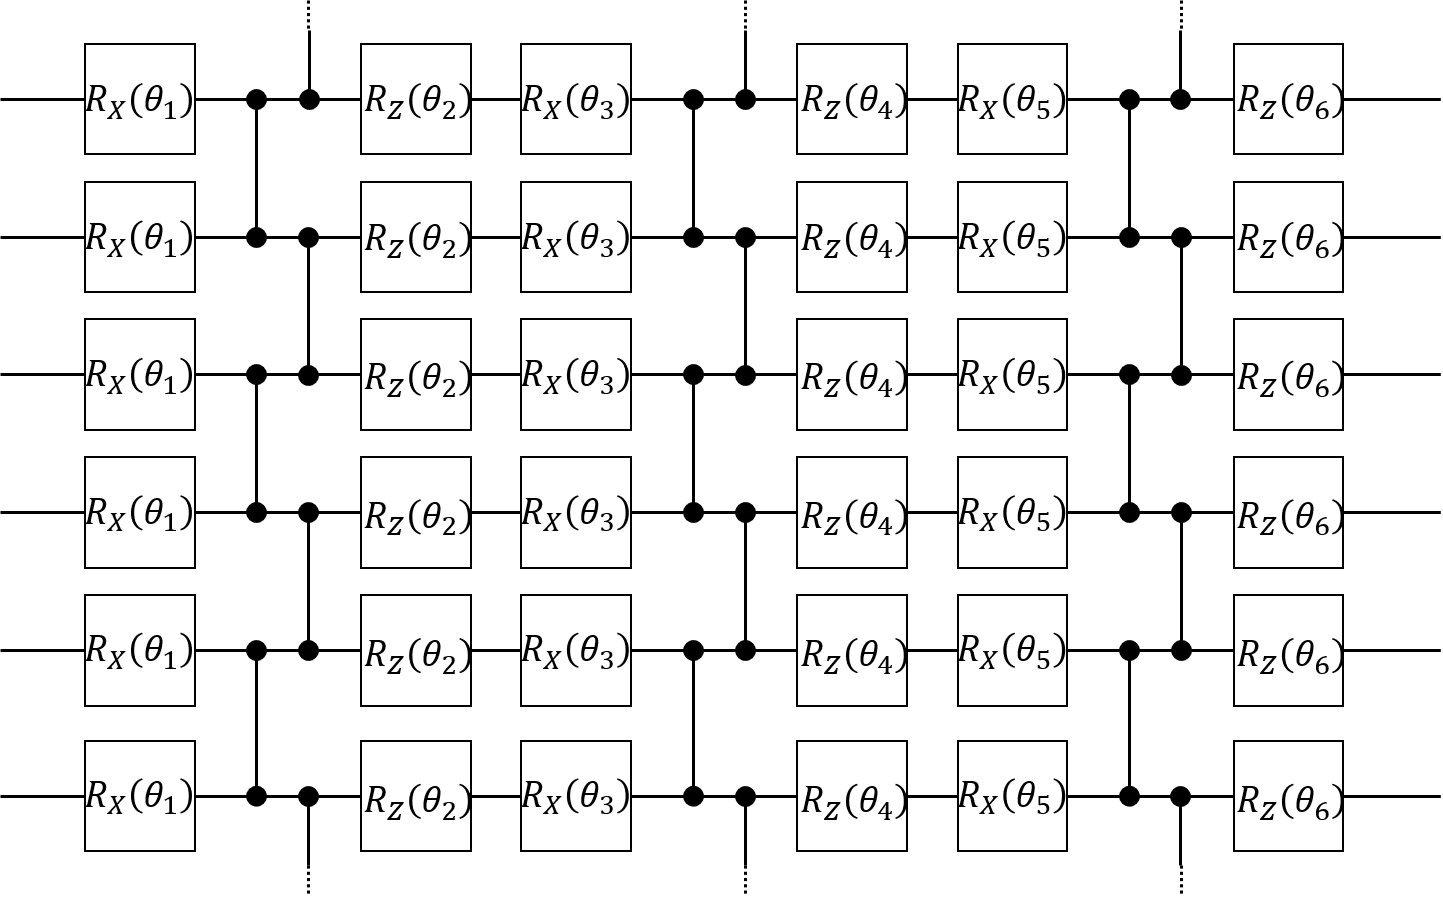

プログラムを実行するとランダムシードの番号とqubit数を聞かれるので指定する。

※ 今回のansatzに対するparent Hamiltonianの基底状態は、12-qubit以上でが一意に定まることが保証される。



In [2]:
import numpy as np
# import cupy as cp
from scipy import linalg
import string
from time import time

from joblib import Parallel, delayed

def Base_10_to_2_list(X, nqubit):
    binX = bin(X)
    binX = binX[2:]
    L = '{:0>'+str(nqubit)+'}'
    binX = L.format(binX)
    binX = list(binX)
    binX = [int(i) for i in binX]
    return binX


def Zrotation(angle):
    U = np.array([
    [np.exp(0.5j*angle), 0],
    [0, np.exp(-0.5j*angle)]
    ])
    return U

def Xrotation(angle):
    U = np.array([
    [np.cos(0.5*angle), 1j*np.sin(0.5*angle)],
    [1j*np.sin(0.5*angle), np.cos(0.5*angle)]
    ])
    return U

def Phasechange_gate():
    U = np.array([
    [1,  1],
    [1, -1]
    ])
    return U

def Deltatenor():
    deltaijk = np.zeros((2,2,2))
    deltaijk[0][0][0] = 1
    deltaijk[1][1][1] = 1
    return deltaijk

def Zero_ket():
    zero_ket = np.array(
    [1, 0])
    return zero_ket


def One_qubit_d3_Ansatz_unit(angle0, angle1,angle2, angle3,angle4, angle5):
    Xrot0 = Xrotation(angle0)
    Zrot0 = Zrotation(angle1)
    Xrot1 = Xrotation(angle2)
    Zrot1 = Zrotation(angle3)
    Xrot2 = Xrotation(angle4)
    Zrot2 = Zrotation(angle5)
    phasechange_gate = Phasechange_gate()
    deltatenor = Deltatenor()
    zero_ket = Zero_ket()

    unit0 = np.einsum('AB, BCi, jCD, jk, DE, E -> Aik', Zrot0, deltatenor, deltatenor, phasechange_gate, Xrot0, zero_ket)
    unit1 = np.einsum('AB, BCi, jCD, jk, DE -> AEik', Zrot1, deltatenor, deltatenor, phasechange_gate, Xrot1)
    unit2 = np.einsum('AB, BCi, jCD, jk, DE -> AEik', Zrot2, deltatenor, deltatenor, phasechange_gate, Xrot2)
    unit = np.einsum('ABij, BCkl, Cmn -> Aijklmn', unit2, unit1, unit0)
    return unit






# nqubit, depth:3の量子状態
def Nqubit_MPS(nqubit, angle_list):
  unit = One_qubit_d3_Ansatz_unit(angle_list[0], angle_list[1], angle_list[2], angle_list[3], angle_list[4], angle_list[5]) # 1qubitあたりの状態。inner_index 6本
  
  ABC = list(string.ascii_uppercase)
  index_segment = ''
  physical_index1 = 'A'
  state = unit
  for n in range(1,nqubit):
    physical_index2 = ABC[n]
    index_segment = '{0}ijklmn, {1}jolpnq -> {0}{1}iokpmq'.format(physical_index1, physical_index2)
    state = np.einsum(index_segment, state, unit)
    print(index_segment)
    physical_index1 += physical_index2
  print('{0}iijjkk -> {0}'.format(physical_index1))
  state = np.einsum('{0}iijjkk -> {0}'.format(physical_index1), state)
  state_conj = np.conj(state)
  return state, state_conj, physical_index1


### MPSから得た量子状態のkernel≠0の密度演算子の探索 ###
def Nqubit_state_locality_checker(nqubit):
    print('enter a int number of random seed')
    randomseed = int(input())
    np.random.seed(seed= randomseed)
    angle_list = np.random.rand(depth*2)*2*np.pi
    print("Answer_angle_list: ", angle_list)
    state, state_conj, physical_index = Nqubit_MPS(nqubit, angle_list)
    renomal_const = np.sqrt(np.einsum(physical_index+','+physical_index, state, state_conj))
    print("<state|state>: ",renomal_const)

    #テンソルから密度行列への書き換え
    flag = 1
    abc = string.ascii_lowercase
    for i in range(2,nqubit):
        if flag ==0:
            pass
        elif i<nqubit:
            physical_index_conj = abc[:i]
            index_temp = '{0}, {1}{2} -> {3}{1}'.format(physical_index, physical_index_conj, physical_index[i:], physical_index[:i]) # 大文字:MPSのphysicalindex,小文字:密度演算子に残すMPS_conjのphysicalindex
            rho = np.einsum(index_temp, state, state_conj)
            print(index_temp)
            rho_matrix = rho.reshape(2**i,2**i)
            rank = np.linalg.matrix_rank(rho_matrix)
            print('{0}-local density matrix rank:{1}(full_rank:{2})'.format(i,rank,2**i))
            if rank < 2**i:
                flag = 0
                local = i
                print('{}-local state'.format(i))
            else:
                pass
        else:
            print('subspace size is higher than {}'.format(nqubit)) #とりあえず4体で打ち止め
            break
    return rho_matrix, rank, local, angle_list, state



### 密度演算子から直交補空間に対する射影演算子の生成 ###
def Null_projector(rho_matrix, rank, local):
    matrix_size = 2**local
    null_space = linalg.null_space(rho_matrix)
    #print(np.linalg.matrix_rank(null_space))
    null_projector = 0
    for i in range(matrix_size - rank):
        null_vec = null_space[:,i]
        null_vec = null_vec.reshape(matrix_size,1)
        null_vec_mat = null_vec @ np.conj(null_vec.T)
        null_projector += null_vec_mat
    return null_projector, matrix_size



### 射影演算子をPauli積の和に変換 ###
#Pauli演算子生成器 Numpyで書き換え
def Paulioperator(i):
  if i == 0:
    p = np.identity(2, dtype=np.complex128)
  elif i == 1:
    p = np.array(
        [[0, 1],
         [1, 0]])
  elif i == 2:
    p = np.array(
        [[0, -1j],
         [1j, 0]])
  elif i == 3:
    p = np.array(
        [[1, 0],
         [0, -1]])
  return p

#n進数配列変換器
def Base_10_to_n(X, n):
    if (int(X/n)):
        return Base_10_to_n(int(X/n), n)+str(X%n)
    return str(X%n)

# 並列計算の1ステップ
def Process_pauliproduct(i, nqubit, local, null_projector):
    l = Base_10_to_n(i, 4)
    size = '{:0>'+str(local)+'}'
    l = size.format(l)
    lis = list(l)
    lis = [int(s) for s in lis]
    #Pauli積の係数を作る部分
    pauliproduct_temp =1
    for j in range(local):
        pauliproduct_temp =np.kron(pauliproduct_temp , Paulioperator(lis[j]))
    paulimatrix = pauliproduct_temp
    print(paulimatrix)
    pauliproducts_factor = np.einsum('ij,ij->', np.conj(null_projector), paulimatrix)/(2**local) # これが早いらしい
    #Pauli積のstrを作る部分
    pauli_product_str = l.replace("0", "I").replace("1", "X").replace("2", "Y").replace("3", "Z")
    pauli_product_lis = list(pauli_product_str)
    pauliproducts_factor_templist = []
    for m in range(nqubit):
      pauli_product=""
      for k in range(local-1):
        pauli_product += str(pauli_product_lis[k]) + " " + str((k+m)%nqubit) + " "
      pauli_product += str(pauli_product_lis[local-1]) + " " + str((local-1+m)%nqubit)
      pauliproducts_factor_templist.append((pauliproducts_factor.real, pauli_product))
    return pauliproducts_factor_templist


### Pauli積の係数をHilbert=shcumit innner productから決める ###
def Parent_Hamiltonian_Paulirepresentation(nqubit):
  rho_matrix, rank, local, answer_angle_list, state = Nqubit_state_locality_checker(nqubit)
  print("(rank, local):", (rank, local))
  null_projector, matrix_size = Null_projector(rho_matrix, rank, local)
  print('Parent Hamiltonian Projector preparation is complete')
  print('Projector rank', np.linalg.matrix_rank(null_projector))
  
  ###並列計算を使う場合 ###
  pauliproducts_factor_list = []
  parallel_list = Parallel(n_jobs=-1, verbose=8)( [delayed(Process_pauliproduct)(i, nqubit, local, null_projector) for i in range(4**local)] )
  for i in range(4**local):
    pauliproducts_factor_list +=parallel_list[i]
  print(pauliproducts_factor_list)
  return pauliproducts_factor_list, answer_angle_list, state

print("This is MPS and Parent Hamiltonian Generator.")
print("Please type the number of qubit.")
nqubit = int(input())
print("The number of qubit = {}".format(nqubit))
# nqubit = 6
depth = 3
start = time()
pauliproducts_factor_list, answer_angle_list, MPS_vec= Parent_Hamiltonian_Paulirepresentation(nqubit)
print('Prepared Parent Hamiltonian!')
print('Calculation time: {}(sec)'.format(time() - start))


This is MPS and Parent Hamiltonian Generator.
Please type the number of qubit.
12
The number of qubit = 12
enter a int number of random seed
1
Answer_angle_list:  [2.62022653e+00 4.52593227e+00 7.18638172e-04 1.89961158e+00
 9.22094457e-01 5.80180502e-01]
Aijklmn, Bjolpnq -> ABiokpmq
ABijklmn, Cjolpnq -> ABCiokpmq
ABCijklmn, Djolpnq -> ABCDiokpmq
ABCDijklmn, Ejolpnq -> ABCDEiokpmq
ABCDEijklmn, Fjolpnq -> ABCDEFiokpmq
ABCDEFijklmn, Gjolpnq -> ABCDEFGiokpmq
ABCDEFGijklmn, Hjolpnq -> ABCDEFGHiokpmq
ABCDEFGHijklmn, Ijolpnq -> ABCDEFGHIiokpmq
ABCDEFGHIijklmn, Jjolpnq -> ABCDEFGHIJiokpmq
ABCDEFGHIJijklmn, Kjolpnq -> ABCDEFGHIJKiokpmq
ABCDEFGHIJKijklmn, Ljolpnq -> ABCDEFGHIJKLiokpmq
ABCDEFGHIJKLiijjkk -> ABCDEFGHIJKL
<state|state>:  (0.9999999999999993+0j)
ABCDEFGHIJKL, abCDEFGHIJKL -> ABab
2-local density matrix rank:4(full_rank:4)
ABCDEFGHIJKL, abcDEFGHIJKL -> ABCabc
3-local density matrix rank:8(full_rank:8)
ABCDEFGHIJKL, abcdEFGHIJKL -> ABCDabcd
4-local density matrix rank:8(full_rank:16)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    2.8s


[(0.4999999999999999, 'I 0 I 1 I 2 I 3'), (0.4999999999999999, 'I 1 I 2 I 3 I 4'), (0.4999999999999999, 'I 2 I 3 I 4 I 5'), (0.4999999999999999, 'I 3 I 4 I 5 I 6'), (0.4999999999999999, 'I 4 I 5 I 6 I 7'), (0.4999999999999999, 'I 5 I 6 I 7 I 8'), (0.4999999999999999, 'I 6 I 7 I 8 I 9'), (0.4999999999999999, 'I 7 I 8 I 9 I 10'), (0.4999999999999999, 'I 8 I 9 I 10 I 11'), (0.4999999999999999, 'I 9 I 10 I 11 I 0'), (0.4999999999999999, 'I 10 I 11 I 0 I 1'), (0.4999999999999999, 'I 11 I 0 I 1 I 2'), (0.010627877794140964, 'I 0 I 1 I 2 X 3'), (0.010627877794140964, 'I 1 I 2 I 3 X 4'), (0.010627877794140964, 'I 2 I 3 I 4 X 5'), (0.010627877794140964, 'I 3 I 4 I 5 X 6'), (0.010627877794140964, 'I 4 I 5 I 6 X 7'), (0.010627877794140964, 'I 5 I 6 I 7 X 8'), (0.010627877794140964, 'I 6 I 7 I 8 X 9'), (0.010627877794140964, 'I 7 I 8 I 9 X 10'), (0.010627877794140964, 'I 8 I 9 I 10 X 11'), (0.010627877794140964, 'I 9 I 10 I 11 X 0'), (0.010627877794140964, 'I 10 I 11 I 0 X 1'), (0.0106278777941409

[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:    3.0s finished


上記のプログラムで使用したランダムパラメータは、
```
Answer_angle_list = [2.62022653e+00 4.52593227e+00 7.18638172e-04 1.89961158e+00
 9.22094457e-01 5.80180502e-01]
```
として、出力されたparent Hamiltonianのpauli積と係数は

```
pauliproducts_factor_list =[(0.4999999999999999, 'I 0 I 1 I 2 I 3'), (0.4999999999999999, 'I 1 I 2 I 3 I 4'), ...]
```
として書き出されている。

これはqulacsのobservableを指定する形式で出力されるため、optimizerのベンチマーク問題として利用する場合は、以下のVQEシミュレータのoptimizerを所望のoptimizerに変更するか、自作のシミュレータで上記のlistをobservbleとして以下のように読み込んでください。
```
def Make_Parent_Hamiltonian(nqubit, pauliproducts_factor_list):
    hamiltonian = pauliproducts_factor_list
    observable = Observable(nqubit)
    for (coef, Pauli_string) in  hamiltonian:
        observable.add_operator(coef, Pauli_string)
    return observable
```

This is Variational Quantum Eigensolver.
The number of qubit = 10
Exact ground Energy:  -1.0333053857003449e-13
One-step calc time: 0.6248641014099121(sec)
Optimization time: 13.011176586151123(sec)
Optimization time: 24.94202709197998(sec)
Optimization time: 29.297081232070923(sec)
Optimization time: 37.40136098861694(sec)
Optimization time: 45.489439487457275(sec)
Optimization time: 49.78724670410156(sec)
Optimization time: 54.062177658081055(sec)
Optimization time: 62.18421483039856(sec)
Optimization time: 70.29262018203735(sec)
Optimization time: 74.58466482162476(sec)
Optimization time: 78.90493035316467(sec)
Optimization time: 83.18345522880554(sec)
Optimization time: 87.47378897666931(sec)
Optimization time: 91.77067470550537(sec)
Optimization time: 96.05303025245667(sec)
Optimization time: 100.32604455947876(sec)
Optimization time: 104.6157078742981(sec)
Optimization time: 108.89891028404236(sec)
Optimization time: 113.17874932289124(sec)
Optimization time: 117.46650004386902(s

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: OptimizeWarning: Unknown solver options: gtol


Optimization time: 3271.703723669052(sec)
Optimization time: 3275.997005701065(sec)
Optimization time: 3283.616256713867(sec)
Optimization time: 3288.847809076309(sec)
Optimization time: 3293.165456056595(sec)
Optimization time: 3297.917944431305(sec)
Optimization time: 3302.7264046669006(sec)
Optimization time: 3307.0125365257263(sec)
Optimization time: 3311.2980387210846(sec)
Optimization time: 3315.6107540130615(sec)
Optimization time: 3319.902058839798(sec)
Optimization time: 3324.210414171219(sec)
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7891392651186397
            Iterations: 12
            Function evaluations: 107
            Gradient evaluations: 12


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

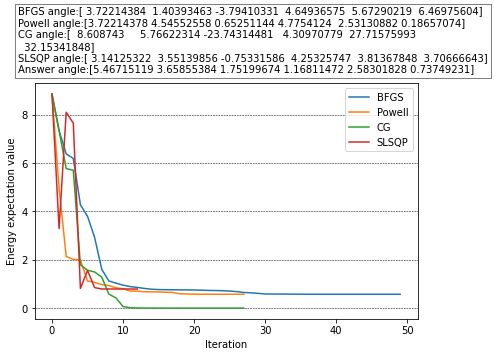

Finish Optimization time: 3324.776319503784(sec)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import qulacs
from scipy.optimize import minimize
from qulacs import QuantumState, QuantumCircuit,  Observable, ParametricQuantumCircuit
from qulacs.gate import X, Y, Z, RX, RY, RZ, CZ, PauliRotation, DenseMatrix, merge, to_matrix_gate
from sympy.physics.quantum.qubit import matrix_to_qubit
import datetime
from google.colab import files

# Parametricで作るとき
def ansatz_circuit(nqubit, depth, angle_list):
    circuit = ParametricQuantumCircuit(nqubit)
    for d in range(0, 2*depth, 2):
      for i in range(nqubit):
        circuit.add_parametric_RX_gate(i, angle_list[d]) # = exp(i angle/2 X_i)
      for i in range(nqubit-1):
        circuit.add_gate(CZ(i, i+1))
      circuit.add_gate(CZ(nqubit-1, 0))
      for i in range(nqubit):
        circuit.add_parametric_RZ_gate(i, angle_list[d+1]) # = exp(i angle/2 Z_i)
    return circuit


#creating pearent hamiltonian
def Make_Parent_Hamiltonian(nqubit, pauliproducts_factor_list):
    hamiltonian = pauliproducts_factor_list
    observable = Observable(nqubit)
    for (coef, Pauli_string) in  hamiltonian:
        observable.add_operator(coef, Pauli_string)
    return observable


def cost(angle_list):
    state = QuantumState(nqubit) #|00000> を準備
    state.set_zero_state()
    for d in range(0, 2*depth, 2): # Parametricで作るとき
      for n in range(nqubit):
        circuit.set_parameter(d*nqubit+n, angle_list[d])
      for i in range(nqubit):
        circuit.set_parameter((d+1)*nqubit+i, angle_list[d+1])
    circuit.update_quantum_state(state) #量子回路を状態に作用
    expectationrnregy = hamiltonian.get_expectation_value(state)
    return expectationrnregy #ハミルトニアンの期待値を計算



def main():
    global nqubit, depth, hamiltonian, circuit
    print("This is Variational Quantum Eigensolver.")
    # print("Please type the number of qubit.")
    # nqubit = int(input())
    print("The number of qubit = {}".format(nqubit))
    depth = 3

    start = time()
    ### VQEによるエネルギー推定 ###
    circuit = ansatz_circuit(nqubit, depth, answer_angle_list)
    # parameter_count = circuit.get_parameter_count()
    # print('number of circuit parameter:', parameter_count)
    
    hamiltonian = Make_Parent_Hamiltonian(nqubit, pauliproducts_factor_list)
    print("Exact ground Energy: ",cost(answer_angle_list))
    print('One-step calc time: {}(sec)'.format(time() - start))

    # init_angle_list = answer_angle_list + (1-np.random.rand(depth*2)*2)
    init_angle_list = np.random.rand(depth*2)*2*np.pi


    def It_Value_append(x, cost_history):
      cost_history.append(cost(x))
      print('Optimization time: {}(sec)'.format(time() - start))
      return cost_history

    cost_history1 = [] 
    cost_history1.append(cost(init_angle_list))
    method1 = "BFGS"
    options = {"disp": True, "maxiter": 100, "gtol": 1e-6}
    opt1 = minimize(cost, init_angle_list, 
                    method=method1, 
                    options=options,
                    callback=lambda x: It_Value_append(x,cost_history1))
                    # callback=lambda x: cost_history1.append(cost(x)))

    cost_history2 = []
    cost_history2.append(cost(init_angle_list))
    method2 = "Powell"
    options = {"disp": True, "maxiter": 100, "xtol": 1e-10, "ftol":1e-6}
    opt2 = minimize(cost, init_angle_list, 
                    method=method2, 
                    options=options,
                    callback=lambda x: It_Value_append(x,cost_history2))


    cost_history3 = []
    cost_history3.append(cost(init_angle_list))
    method3 = "CG"
    options = {"disp": True, "maxiter": 100, "gtol": 1e-6}
    opt3 = minimize(cost, init_angle_list, 
                    method=method3, 
                    options=options,
                    callback=lambda x: It_Value_append(x,cost_history3))

    cost_history4 = []
    cost_history4.append(cost(init_angle_list))
    method4 = "SLSQP"
    options = {"disp": True, "maxiter": 100, "gtol": 1e-6}
    opt4 = minimize(cost, init_angle_list, 
                    method=method4, 
                    options=options,
                    callback=lambda x: It_Value_append(x,cost_history4))

    
    # グラフ描画部分
    fig = plt.figure(tight_layout = True)
    # add_subplot()でグラフを描画する領域を追加する．引数は行，列，場所
    ax1 = fig.add_subplot(1, 1, 1,  xlabel='Iteration', ylabel='Energy expectation value')
    
    plt.rcParams["font.size"] = 10
    ax1.grid(axis='y', color='black', lw=0.5, ls='--')
    ax1.plot(cost_history1, label=method1)
    ax1.plot(cost_history2, label=method2)
    ax1.plot(cost_history3, label=method3)
    ax1.plot(cost_history4, label=method4)
    ax1.legend()

    boxdic = {"facecolor" : "white", "boxstyle": 'square', "alpha" : 0.5}
    fig.text(0.05, 1, 
    str(method1)+" angle:"+str(opt1.x)+"\n"+
    str(method2)+" angle:"+str(opt2.x)+"\n"+
    str(method3)+" angle:"+str(opt3.x)+"\n"+
    str(method4)+" angle:"+str(opt4.x)+"\n"+
    "Answer angle:"+str(answer_angle_list)# +"\n"+
    # str(method1)+" number of function evaluation:"+str(opt1.nfev)+"\n"+
    # str(method2)+" number of function evaluation:"+str(opt2.nfev)+"\n"+
    # str(method3)+" number of function evaluation:"+str(opt3.nfev)+"\n"+
    # str(method4)+" number of function evaluation:"+str(opt4.nfev)
    , fontsize=10, fontdict=None, bbox=boxdic)

    now = datetime.datetime.now()
    plt.savefig("{0}-qubit_depth{1}_{2}.svg".format(nqubit, depth, now.strftime('%y%m%d_%H%M')), bbox_inches = "tight", format='svg')
    files.download("{0}-qubit_depth{1}_{2}.svg".format(nqubit, depth, now.strftime('%y%m%d_%H%M')))
    plt.show()
    print('Finish Optimization time: {}(sec)'.format(time() - start))


if __name__ == '__main__':
    main()